In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 2.

In [13]:
import os

# Print period for accuracy.
print_period = 100

# Hyper-parameters for training 
birdclef_batch = 32
birdclef_epoch = 50

# Learning Rate.
learning_rate_2 = 0.0008

# L2 Regularization Hyperparamter
weight_decay_2 = 0.01

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'log_scores': log_scores,
            'fbeta_scores': fbeta_scores,
            }, './bird_specificator.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch, ckpt_enable=True):
    val_losses = []
    train_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    if ckpt_enable and os.path.exists('./bird_specificator.pt'):
        ckpt = torch.load('./bird_specificator.pt')
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        train_losses = ckpt['train_losses']
        val_losses = ckpt['val_losses']
        log_scores = ckpt['log_scores']
        fbeta_scores = ckpt['fbeta_scores']
        saved_epoch = ckpt['epoch']
    
    for e in range(epoch):
        if e <= saved_epoch:
            continue
            
        epoch_losses = []
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)
        
        # every epoch, save the model
        checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, e)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_2, weight_decay=weight_decay_2, momentum=0.9)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=1e-5)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [15]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [16]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                               | 1/1178 [00:08<2:50:19,  8.68s/it]

Iteration 0, loss = 6.0913


  9%|██████▊                                                                        | 101/1178 [01:01<09:10,  1.96it/s]

Iteration 100, loss = 5.9645


 17%|█████████████▍                                                                 | 201/1178 [01:53<08:22,  1.94it/s]

Iteration 200, loss = 5.9263


 26%|████████████████████▏                                                          | 301/1178 [02:45<07:24,  1.97it/s]

Iteration 300, loss = 5.6910


 34%|██████████████████████████▉                                                    | 401/1178 [03:37<07:03,  1.83it/s]

Iteration 400, loss = 5.2831


 43%|█████████████████████████████████▌                                             | 501/1178 [04:31<06:30,  1.73it/s]

Iteration 500, loss = 5.3429


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:25<05:07,  1.88it/s]

Iteration 600, loss = 5.1088


 60%|███████████████████████████████████████████████                                | 701/1178 [06:18<05:00,  1.59it/s]

Iteration 700, loss = 4.5956


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:12<03:24,  1.84it/s]

Iteration 800, loss = 4.4463


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:05<02:21,  1.95it/s]

Iteration 900, loss = 4.5687


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:57<01:37,  1.82it/s]

Iteration 1000, loss = 4.4478


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:52<00:45,  1.68it/s]

Iteration 1100, loss = 4.1737


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:33<00:00,  1.86it/s]


Checking accuracy score on validation set.

Accuracy: 2593 / 12575 correct (20.62)
Log Loss score:	4.05
Fbeta-score (beta=1): 	0.21
Training model 2, epoch 2


  0%|                                                                                 | 1/1178 [00:00<10:14,  1.92it/s]

Iteration 0, loss = 3.9149


  9%|██████▊                                                                        | 101/1178 [00:45<08:01,  2.24it/s]

Iteration 100, loss = 3.2723


 17%|█████████████▍                                                                 | 201/1178 [01:30<07:09,  2.27it/s]

Iteration 200, loss = 4.0668


 26%|████████████████████▏                                                          | 301/1178 [02:16<06:04,  2.40it/s]

Iteration 300, loss = 4.3383


 34%|██████████████████████████▉                                                    | 401/1178 [03:01<05:39,  2.29it/s]

Iteration 400, loss = 3.4840


 43%|█████████████████████████████████▌                                             | 501/1178 [03:47<04:58,  2.27it/s]

Iteration 500, loss = 4.9998


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:33<04:15,  2.26it/s]

Iteration 600, loss = 3.0551


 60%|███████████████████████████████████████████████                                | 701/1178 [05:19<03:31,  2.26it/s]

Iteration 700, loss = 3.6867


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:05<02:46,  2.26it/s]

Iteration 800, loss = 4.1844


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:52<01:58,  2.34it/s]

Iteration 900, loss = 4.2070


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:37<01:19,  2.22it/s]

Iteration 1000, loss = 3.4082


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [08:25<00:34,  2.22it/s]

Iteration 1100, loss = 3.5864


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [09:02<00:00,  2.17it/s]


Checking accuracy score on validation set.

Accuracy: 3525 / 12575 correct (28.03)
Log Loss score:	3.56
Fbeta-score (beta=1): 	0.28
Training model 2, epoch 3


  0%|                                                                                 | 1/1178 [00:00<08:47,  2.23it/s]

Iteration 0, loss = 3.0822


  9%|██████▊                                                                        | 101/1178 [00:42<07:11,  2.50it/s]

Iteration 100, loss = 3.0228


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:41,  2.43it/s]

Iteration 200, loss = 3.4530


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:52,  2.49it/s]

Iteration 300, loss = 3.2469


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<04:48,  2.69it/s]

Iteration 400, loss = 2.4267


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:33,  2.48it/s]

Iteration 500, loss = 3.0095


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<03:56,  2.44it/s]

Iteration 600, loss = 3.1407


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:07,  2.54it/s]

Iteration 700, loss = 3.0920


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:31<02:34,  2.45it/s]

Iteration 800, loss = 3.2553


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:12<02:03,  2.24it/s]

Iteration 900, loss = 3.0460


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:53<01:08,  2.58it/s]

Iteration 1000, loss = 2.9782


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:36<00:31,  2.47it/s]

Iteration 1100, loss = 3.4134


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:08<00:00,  2.41it/s]


Checking accuracy score on validation set.

Accuracy: 4159 / 12575 correct (33.07)
Log Loss score:	3.25
Fbeta-score (beta=1): 	0.33
Training model 2, epoch 4


  0%|                                                                                 | 1/1178 [00:00<08:56,  2.19it/s]

Iteration 0, loss = 3.2301


  9%|██████▊                                                                        | 101/1178 [00:42<08:00,  2.24it/s]

Iteration 100, loss = 2.5091


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:47,  2.40it/s]

Iteration 200, loss = 3.2224


 26%|████████████████████▏                                                          | 301/1178 [02:05<06:11,  2.36it/s]

Iteration 300, loss = 2.5881


 34%|██████████████████████████▉                                                    | 401/1178 [02:47<06:25,  2.02it/s]

Iteration 400, loss = 3.1226


 43%|█████████████████████████████████▌                                             | 501/1178 [03:29<04:21,  2.59it/s]

Iteration 500, loss = 2.9522


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:10<03:57,  2.43it/s]

Iteration 600, loss = 3.7988


 60%|███████████████████████████████████████████████                                | 701/1178 [04:52<03:11,  2.50it/s]

Iteration 700, loss = 2.9877


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:34<02:43,  2.30it/s]

Iteration 800, loss = 2.7849


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:17<01:45,  2.61it/s]

Iteration 900, loss = 3.0149


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:59<01:13,  2.39it/s]

Iteration 1000, loss = 3.0625


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:41<00:32,  2.35it/s]

Iteration 1100, loss = 3.2743


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:12<00:00,  2.39it/s]


Checking accuracy score on validation set.

Accuracy: 4383 / 12575 correct (34.85)
Log Loss score:	3.13
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 5


  0%|                                                                                 | 1/1178 [00:00<10:15,  1.91it/s]

Iteration 0, loss = 2.5127


  9%|██████▊                                                                        | 101/1178 [00:41<07:29,  2.40it/s]

Iteration 100, loss = 3.2530


 17%|█████████████▍                                                                 | 201/1178 [01:24<07:13,  2.25it/s]

Iteration 200, loss = 2.6226


 26%|████████████████████▏                                                          | 301/1178 [02:06<06:44,  2.17it/s]

Iteration 300, loss = 2.9540


 34%|██████████████████████████▉                                                    | 401/1178 [02:48<05:37,  2.30it/s]

Iteration 400, loss = 3.8444


 43%|█████████████████████████████████▌                                             | 501/1178 [03:29<04:55,  2.29it/s]

Iteration 500, loss = 2.9071


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:10<04:10,  2.31it/s]

Iteration 600, loss = 2.5228


 60%|███████████████████████████████████████████████                                | 701/1178 [04:52<03:09,  2.52it/s]

Iteration 700, loss = 3.1994


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:35<02:54,  2.16it/s]

Iteration 800, loss = 2.9115


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:16<02:03,  2.25it/s]

Iteration 900, loss = 2.7202


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:59<01:11,  2.47it/s]

Iteration 1000, loss = 2.7828


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:41<00:34,  2.24it/s]

Iteration 1100, loss = 1.9066


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:13<00:00,  2.39it/s]


Checking accuracy score on validation set.

Accuracy: 4466 / 12575 correct (35.51)
Log Loss score:	3.09
Fbeta-score (beta=1): 	0.36
Training model 2, epoch 6


  0%|                                                                                 | 1/1178 [00:00<08:50,  2.22it/s]

Iteration 0, loss = 2.1508


  9%|██████▊                                                                        | 101/1178 [00:42<08:45,  2.05it/s]

Iteration 100, loss = 2.9177


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:31,  2.49it/s]

Iteration 200, loss = 3.0631


 26%|████████████████████▏                                                          | 301/1178 [02:06<06:41,  2.19it/s]

Iteration 300, loss = 2.9559


 34%|██████████████████████████▉                                                    | 401/1178 [02:48<05:27,  2.37it/s]

Iteration 400, loss = 3.4655


 43%|█████████████████████████████████▌                                             | 501/1178 [03:30<04:17,  2.63it/s]

Iteration 500, loss = 2.5122


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:10<04:08,  2.33it/s]

Iteration 600, loss = 2.6396


 60%|███████████████████████████████████████████████                                | 701/1178 [04:53<03:18,  2.40it/s]

Iteration 700, loss = 2.5168


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:36<02:39,  2.37it/s]

Iteration 800, loss = 2.9728


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:18<02:00,  2.30it/s]

Iteration 900, loss = 3.0843


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:00<01:16,  2.30it/s]

Iteration 1000, loss = 2.9998


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:43<00:31,  2.44it/s]

Iteration 1100, loss = 2.5167


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:16<00:00,  2.37it/s]


Checking accuracy score on validation set.

Accuracy: 4692 / 12575 correct (37.31)
Log Loss score:	3.01
Fbeta-score (beta=1): 	0.37
Training model 2, epoch 7


  0%|                                                                                 | 1/1178 [00:00<08:14,  2.38it/s]

Iteration 0, loss = 2.9426


  9%|██████▊                                                                        | 101/1178 [00:42<07:09,  2.51it/s]

Iteration 100, loss = 2.6975


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:42,  2.43it/s]

Iteration 200, loss = 2.7227


 26%|████████████████████▏                                                          | 301/1178 [02:06<05:57,  2.45it/s]

Iteration 300, loss = 2.3276


 34%|██████████████████████████▉                                                    | 401/1178 [02:48<05:42,  2.27it/s]

Iteration 400, loss = 2.4773


 43%|█████████████████████████████████▌                                             | 501/1178 [03:31<04:58,  2.27it/s]

Iteration 500, loss = 2.4504


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:13<04:18,  2.23it/s]

Iteration 600, loss = 2.5427


 60%|███████████████████████████████████████████████                                | 701/1178 [04:56<03:28,  2.28it/s]

Iteration 700, loss = 2.2690


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:39<02:46,  2.26it/s]

Iteration 800, loss = 2.8554


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:20<01:41,  2.73it/s]

Iteration 900, loss = 3.0443


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:00<01:16,  2.31it/s]

Iteration 1000, loss = 2.7582


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:40<00:32,  2.36it/s]

Iteration 1100, loss = 2.9546


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:11<00:00,  2.40it/s]


Checking accuracy score on validation set.

Accuracy: 5079 / 12575 correct (40.39)
Log Loss score:	2.85
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 8


  0%|                                                                                 | 1/1178 [00:00<08:17,  2.36it/s]

Iteration 0, loss = 2.0821


  9%|██████▊                                                                        | 101/1178 [00:40<08:51,  2.03it/s]

Iteration 100, loss = 3.1104


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:30,  2.50it/s]

Iteration 200, loss = 2.7235


 26%|████████████████████▏                                                          | 301/1178 [02:01<06:02,  2.42it/s]

Iteration 300, loss = 2.2662


 34%|██████████████████████████▉                                                    | 401/1178 [02:42<05:37,  2.30it/s]

Iteration 400, loss = 2.0425


 43%|█████████████████████████████████▌                                             | 501/1178 [03:23<04:26,  2.54it/s]

Iteration 500, loss = 2.4438


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:01<03:42,  2.60it/s]

Iteration 600, loss = 2.4391


 60%|███████████████████████████████████████████████                                | 701/1178 [04:41<02:59,  2.65it/s]

Iteration 700, loss = 2.5801


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:21<02:36,  2.41it/s]

Iteration 800, loss = 2.9572


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:01<01:48,  2.56it/s]

Iteration 900, loss = 2.4949


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:40<01:04,  2.74it/s]

Iteration 1000, loss = 2.3255


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:21<00:32,  2.36it/s]

Iteration 1100, loss = 2.9541


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [07:51<00:00,  2.50it/s]


Checking accuracy score on validation set.

Accuracy: 4718 / 12575 correct (37.52)
Log Loss score:	3.01
Fbeta-score (beta=1): 	0.38
Training model 2, epoch 9


  0%|                                                                                 | 1/1178 [00:00<10:10,  1.93it/s]

Iteration 0, loss = 2.4269


  9%|██████▊                                                                        | 101/1178 [00:40<07:13,  2.48it/s]

Iteration 100, loss = 2.1309


 17%|█████████████▍                                                                 | 201/1178 [01:20<06:21,  2.56it/s]

Iteration 200, loss = 2.7976


 26%|████████████████████▏                                                          | 301/1178 [02:00<05:52,  2.49it/s]

Iteration 300, loss = 2.7505


 34%|██████████████████████████▉                                                    | 401/1178 [02:40<05:20,  2.42it/s]

Iteration 400, loss = 2.9476


 43%|█████████████████████████████████▌                                             | 501/1178 [03:19<04:43,  2.39it/s]

Iteration 500, loss = 2.4922


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:01<03:55,  2.45it/s]

Iteration 600, loss = 2.7487


 60%|███████████████████████████████████████████████                                | 701/1178 [04:41<03:12,  2.48it/s]

Iteration 700, loss = 3.0907


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:19<02:15,  2.78it/s]

Iteration 800, loss = 2.8102


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [05:59<01:48,  2.55it/s]

Iteration 900, loss = 3.1309


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:39<01:10,  2.50it/s]

Iteration 1000, loss = 3.0110


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:19<00:30,  2.55it/s]

Iteration 1100, loss = 2.1595


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [07:50<00:00,  2.51it/s]


Checking accuracy score on validation set.

Accuracy: 4887 / 12575 correct (38.86)
Log Loss score:	2.90
Fbeta-score (beta=1): 	0.39
Training model 2, epoch 10


  0%|                                                                                 | 1/1178 [00:00<09:41,  2.02it/s]

Iteration 0, loss = 2.0751


  9%|██████▊                                                                        | 101/1178 [00:42<07:30,  2.39it/s]

Iteration 100, loss = 2.2538


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:34,  2.48it/s]

Iteration 200, loss = 2.4693


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:09,  2.37it/s]

Iteration 300, loss = 2.8102


 34%|██████████████████████████▉                                                    | 401/1178 [02:41<05:15,  2.46it/s]

Iteration 400, loss = 2.5059


 43%|█████████████████████████████████▌                                             | 501/1178 [03:21<04:31,  2.50it/s]

Iteration 500, loss = 3.2933


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:01<03:26,  2.80it/s]

Iteration 600, loss = 2.7497


 60%|███████████████████████████████████████████████                                | 701/1178 [04:42<03:08,  2.54it/s]

Iteration 700, loss = 2.7439


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:22<02:27,  2.56it/s]

Iteration 800, loss = 2.7798


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:02<01:45,  2.64it/s]

Iteration 900, loss = 3.0013


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:42<01:06,  2.68it/s]

Iteration 1000, loss = 2.7435


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:22<00:33,  2.28it/s]

Iteration 1100, loss = 2.4463


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [07:52<00:00,  2.49it/s]


Checking accuracy score on validation set.

Accuracy: 4412 / 12575 correct (35.09)
Log Loss score:	3.13
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 11


  0%|                                                                                 | 1/1178 [00:00<09:13,  2.13it/s]

Iteration 0, loss = 2.8939


  9%|██████▊                                                                        | 101/1178 [00:40<07:13,  2.48it/s]

Iteration 100, loss = 2.7750


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:37,  2.46it/s]

Iteration 200, loss = 2.4618


 26%|████████████████████▏                                                          | 301/1178 [02:01<05:39,  2.58it/s]

Iteration 300, loss = 2.1655


 34%|██████████████████████████▉                                                    | 401/1178 [02:40<05:03,  2.56it/s]

Iteration 400, loss = 2.7127


 43%|█████████████████████████████████▌                                             | 501/1178 [03:20<04:51,  2.32it/s]

Iteration 500, loss = 2.6676


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:00<03:58,  2.41it/s]

Iteration 600, loss = 2.8618


 60%|███████████████████████████████████████████████                                | 701/1178 [04:40<03:05,  2.57it/s]

Iteration 700, loss = 3.2172


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:20<02:37,  2.39it/s]

Iteration 800, loss = 3.5002


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:01<01:59,  2.32it/s]

Iteration 900, loss = 2.4638


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:40<01:05,  2.70it/s]

Iteration 1000, loss = 3.0476


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:21<00:28,  2.71it/s]

Iteration 1100, loss = 2.3187


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [07:52<00:00,  2.50it/s]


Checking accuracy score on validation set.

Accuracy: 4662 / 12575 correct (37.07)
Log Loss score:	3.06
Fbeta-score (beta=1): 	0.37
Training model 2, epoch 12


  0%|                                                                                 | 1/1178 [00:00<08:13,  2.39it/s]

Iteration 0, loss = 2.0151


  9%|██████▊                                                                        | 101/1178 [00:40<07:25,  2.42it/s]

Iteration 100, loss = 2.1479


 17%|█████████████▍                                                                 | 201/1178 [01:19<06:44,  2.41it/s]

Iteration 200, loss = 2.4697


 26%|████████████████████▏                                                          | 301/1178 [02:00<05:48,  2.52it/s]

Iteration 300, loss = 2.3159


 34%|██████████████████████████▉                                                    | 401/1178 [02:41<05:54,  2.19it/s]

Iteration 400, loss = 2.4946


 43%|█████████████████████████████████▌                                             | 501/1178 [03:21<04:25,  2.55it/s]

Iteration 500, loss = 3.1953


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:01<04:01,  2.39it/s]

Iteration 600, loss = 2.6990


 60%|███████████████████████████████████████████████                                | 701/1178 [04:41<02:57,  2.69it/s]

Iteration 700, loss = 2.0200


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:21<02:42,  2.32it/s]

Iteration 800, loss = 2.3215


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:01<01:52,  2.46it/s]

Iteration 900, loss = 1.5707


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:41<01:10,  2.52it/s]

Iteration 1000, loss = 2.8746


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:21<00:29,  2.61it/s]

Iteration 1100, loss = 2.3143


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [07:52<00:00,  2.49it/s]


Checking accuracy score on validation set.

Accuracy: 5203 / 12575 correct (41.38)
Log Loss score:	2.92
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 13


  0%|                                                                                 | 1/1178 [00:00<09:36,  2.04it/s]

Iteration 0, loss = 3.2438


  9%|██████▊                                                                        | 101/1178 [00:40<07:36,  2.36it/s]

Iteration 100, loss = 2.0594


 17%|█████████████▍                                                                 | 201/1178 [01:20<06:42,  2.42it/s]

Iteration 200, loss = 2.3046


 26%|████████████████████▏                                                          | 301/1178 [01:59<05:39,  2.58it/s]

Iteration 300, loss = 2.2304


 34%|██████████████████████████▉                                                    | 401/1178 [02:40<05:34,  2.32it/s]

Iteration 400, loss = 2.1581


 43%|█████████████████████████████████▌                                             | 501/1178 [03:19<04:17,  2.63it/s]

Iteration 500, loss = 2.9814


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:00<03:47,  2.53it/s]

Iteration 600, loss = 2.3922


 60%|███████████████████████████████████████████████                                | 701/1178 [04:40<03:24,  2.34it/s]

Iteration 700, loss = 2.4665


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:22<02:25,  2.59it/s]

Iteration 800, loss = 2.3688


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:03<01:54,  2.41it/s]

Iteration 900, loss = 2.8582


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:43<01:12,  2.44it/s]

Iteration 1000, loss = 2.3585


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:24<00:28,  2.67it/s]

Iteration 1100, loss = 2.7951


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [07:55<00:00,  2.48it/s]


Checking accuracy score on validation set.

Accuracy: 5156 / 12575 correct (41.00)
Log Loss score:	2.87
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 14


  0%|                                                                                 | 1/1178 [00:00<09:14,  2.12it/s]

Iteration 0, loss = 2.0274


  9%|██████▊                                                                        | 101/1178 [00:43<07:12,  2.49it/s]

Iteration 100, loss = 2.6122


 17%|█████████████▍                                                                 | 201/1178 [01:24<07:39,  2.13it/s]

Iteration 200, loss = 1.9903


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:36,  2.60it/s]

Iteration 300, loss = 2.1737


 34%|██████████████████████████▉                                                    | 401/1178 [02:47<05:47,  2.24it/s]

Iteration 400, loss = 2.5343


 43%|█████████████████████████████████▌                                             | 501/1178 [03:29<05:26,  2.07it/s]

Iteration 500, loss = 2.6567


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:11<04:16,  2.25it/s]

Iteration 600, loss = 2.3409


 60%|███████████████████████████████████████████████                                | 701/1178 [04:52<03:33,  2.24it/s]

Iteration 700, loss = 2.2321


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:34<02:36,  2.40it/s]

Iteration 800, loss = 2.9569


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:16<01:58,  2.35it/s]

Iteration 900, loss = 3.0784


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:57<01:10,  2.49it/s]

Iteration 1000, loss = 2.5784


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:39<00:31,  2.42it/s]

Iteration 1100, loss = 2.1191


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:11<00:00,  2.40it/s]


Checking accuracy score on validation set.

Accuracy: 5192 / 12575 correct (41.29)
Log Loss score:	2.85
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 15


  0%|                                                                                 | 1/1178 [00:00<10:24,  1.88it/s]

Iteration 0, loss = 2.6407


  9%|██████▊                                                                        | 101/1178 [00:43<07:59,  2.25it/s]

Iteration 100, loss = 1.8197


 17%|█████████████▍                                                                 | 201/1178 [01:26<06:24,  2.54it/s]

Iteration 200, loss = 1.8831


 26%|████████████████████▏                                                          | 301/1178 [02:07<06:25,  2.28it/s]

Iteration 300, loss = 2.2467


 34%|██████████████████████████▉                                                    | 401/1178 [02:49<05:20,  2.42it/s]

Iteration 400, loss = 1.9223


 43%|█████████████████████████████████▌                                             | 501/1178 [03:31<04:40,  2.41it/s]

Iteration 500, loss = 2.2336


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:13<04:51,  1.98it/s]

Iteration 600, loss = 2.3917


 60%|███████████████████████████████████████████████                                | 701/1178 [04:54<03:15,  2.45it/s]

Iteration 700, loss = 2.1543


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:35<02:43,  2.31it/s]

Iteration 800, loss = 2.9424


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:17<01:44,  2.65it/s]

Iteration 900, loss = 3.0255


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:59<01:14,  2.39it/s]

Iteration 1000, loss = 2.3285


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:40<00:33,  2.31it/s]

Iteration 1100, loss = 2.4437


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:13<00:00,  2.39it/s]


Checking accuracy score on validation set.

Accuracy: 5149 / 12575 correct (40.95)
Log Loss score:	2.97
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 16


  0%|                                                                                 | 1/1178 [00:00<08:54,  2.20it/s]

Iteration 0, loss = 2.6851


  9%|██████▊                                                                        | 101/1178 [00:43<08:10,  2.20it/s]

Iteration 100, loss = 2.3131


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:54,  2.36it/s]

Iteration 200, loss = 2.4354


 26%|████████████████████▏                                                          | 301/1178 [02:07<06:19,  2.31it/s]

Iteration 300, loss = 2.0731


 34%|██████████████████████████▉                                                    | 401/1178 [02:49<05:49,  2.22it/s]

Iteration 400, loss = 2.4455


 43%|█████████████████████████████████▌                                             | 501/1178 [03:30<04:44,  2.38it/s]

Iteration 500, loss = 1.5819


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:10<04:02,  2.38it/s]

Iteration 600, loss = 2.1810


 60%|███████████████████████████████████████████████                                | 701/1178 [04:52<03:34,  2.23it/s]

Iteration 700, loss = 2.3612


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:35<02:44,  2.29it/s]

Iteration 800, loss = 2.1644


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:16<01:53,  2.43it/s]

Iteration 900, loss = 2.8122


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:58<01:22,  2.15it/s]

Iteration 1000, loss = 2.1416


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:40<00:34,  2.22it/s]

Iteration 1100, loss = 2.2447


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:11<00:00,  2.40it/s]


Checking accuracy score on validation set.

Accuracy: 5265 / 12575 correct (41.87)
Log Loss score:	2.86
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 17


  0%|                                                                                 | 1/1178 [00:00<08:54,  2.20it/s]

Iteration 0, loss = 2.0209


  9%|██████▊                                                                        | 101/1178 [00:40<07:28,  2.40it/s]

Iteration 100, loss = 1.9583


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:13,  2.62it/s]

Iteration 200, loss = 2.1685


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:12,  2.35it/s]

Iteration 300, loss = 2.0889


 34%|██████████████████████████▉                                                    | 401/1178 [02:42<05:12,  2.48it/s]

Iteration 400, loss = 1.9489


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<05:17,  2.13it/s]

Iteration 500, loss = 2.2004


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:57,  2.43it/s]

Iteration 600, loss = 2.4314


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:20,  2.37it/s]

Iteration 700, loss = 2.6926


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:45,  2.28it/s]

Iteration 800, loss = 2.1417


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:12<01:52,  2.46it/s]

Iteration 900, loss = 1.7195


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:55<01:09,  2.53it/s]

Iteration 1000, loss = 2.4902


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:38<00:32,  2.38it/s]

Iteration 1100, loss = 2.0715


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:10<00:00,  2.40it/s]


Checking accuracy score on validation set.

Accuracy: 5237 / 12575 correct (41.65)
Log Loss score:	2.87
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 18


  0%|                                                                                 | 1/1178 [00:00<09:06,  2.16it/s]

Iteration 0, loss = 1.8810


  9%|██████▊                                                                        | 101/1178 [00:41<07:21,  2.44it/s]

Iteration 100, loss = 1.6858


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:18,  2.58it/s]

Iteration 200, loss = 1.7645


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:49,  2.51it/s]

Iteration 300, loss = 1.8178


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:16,  2.46it/s]

Iteration 400, loss = 1.9982


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:21,  2.59it/s]

Iteration 500, loss = 1.8415


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:08<03:58,  2.42it/s]

Iteration 600, loss = 2.4097


 60%|███████████████████████████████████████████████                                | 701/1178 [04:50<03:04,  2.58it/s]

Iteration 700, loss = 2.5059


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:32<02:30,  2.50it/s]

Iteration 800, loss = 2.4587


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:14<01:56,  2.39it/s]

Iteration 900, loss = 2.0222


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:55<01:05,  2.70it/s]

Iteration 1000, loss = 2.5722


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:38<00:32,  2.38it/s]

Iteration 1100, loss = 1.5365


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:09<00:00,  2.41it/s]


Checking accuracy score on validation set.

Accuracy: 5272 / 12575 correct (41.92)
Log Loss score:	2.88
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 19


  0%|                                                                                 | 1/1178 [00:00<12:15,  1.60it/s]

Iteration 0, loss = 2.1162


  9%|██████▊                                                                        | 101/1178 [00:43<07:37,  2.35it/s]

Iteration 100, loss = 1.9952


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:15,  2.60it/s]

Iteration 200, loss = 1.2987


 26%|████████████████████▏                                                          | 301/1178 [02:05<06:08,  2.38it/s]

Iteration 300, loss = 1.9062


 34%|██████████████████████████▉                                                    | 401/1178 [02:46<04:58,  2.60it/s]

Iteration 400, loss = 1.8503


 43%|█████████████████████████████████▌                                             | 501/1178 [03:27<04:51,  2.32it/s]

Iteration 500, loss = 1.9853


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<04:03,  2.37it/s]

Iteration 600, loss = 2.2800


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:25,  2.32it/s]

Iteration 700, loss = 1.8120


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:31<02:43,  2.30it/s]

Iteration 800, loss = 1.9755


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:12<01:54,  2.42it/s]

Iteration 900, loss = 1.4746


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:54<01:06,  2.68it/s]

Iteration 1000, loss = 1.5295


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:35<00:33,  2.27it/s]

Iteration 1100, loss = 2.4653


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5389 / 12575 correct (42.85)
Log Loss score:	2.85
Fbeta-score (beta=1): 	0.43
Training model 2, epoch 20


  0%|                                                                                 | 1/1178 [00:00<08:54,  2.20it/s]

Iteration 0, loss = 1.7906


  9%|██████▊                                                                        | 101/1178 [00:42<07:02,  2.55it/s]

Iteration 100, loss = 2.0022


 17%|█████████████▍                                                                 | 201/1178 [01:23<06:11,  2.63it/s]

Iteration 200, loss = 1.3255


 26%|████████████████████▏                                                          | 301/1178 [02:05<06:03,  2.41it/s]

Iteration 300, loss = 1.5579


 34%|██████████████████████████▉                                                    | 401/1178 [02:48<05:14,  2.47it/s]

Iteration 400, loss = 1.7379


 43%|█████████████████████████████████▌                                             | 501/1178 [03:30<04:46,  2.37it/s]

Iteration 500, loss = 2.1323


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:12<03:53,  2.47it/s]

Iteration 600, loss = 2.1546


 60%|███████████████████████████████████████████████                                | 701/1178 [04:54<03:13,  2.47it/s]

Iteration 700, loss = 1.7853


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:35<02:30,  2.51it/s]

Iteration 800, loss = 1.7425


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:17<01:47,  2.58it/s]

Iteration 900, loss = 2.3019


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:58<01:09,  2.56it/s]

Iteration 1000, loss = 2.0596


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:41<00:28,  2.67it/s]

Iteration 1100, loss = 2.3819


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:14<00:00,  2.38it/s]


Checking accuracy score on validation set.

Accuracy: 5616 / 12575 correct (44.66)
Log Loss score:	2.78
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 21


  0%|                                                                                 | 1/1178 [00:00<08:46,  2.24it/s]

Iteration 0, loss = 1.5529


  9%|██████▊                                                                        | 101/1178 [00:42<07:41,  2.33it/s]

Iteration 100, loss = 1.8136


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:19,  2.58it/s]

Iteration 200, loss = 1.8593


 26%|████████████████████▏                                                          | 301/1178 [02:03<05:35,  2.62it/s]

Iteration 300, loss = 1.8422


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:21,  2.41it/s]

Iteration 400, loss = 2.2550


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<05:06,  2.21it/s]

Iteration 500, loss = 1.9260


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:08<04:03,  2.37it/s]

Iteration 600, loss = 1.5942


 60%|███████████████████████████████████████████████                                | 701/1178 [04:52<03:39,  2.17it/s]

Iteration 700, loss = 2.5824


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:33<02:28,  2.54it/s]

Iteration 800, loss = 1.0652


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:16<01:51,  2.49it/s]

Iteration 900, loss = 2.2639


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:58<01:15,  2.33it/s]

Iteration 1000, loss = 1.3621


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:40<00:29,  2.65it/s]

Iteration 1100, loss = 2.1323


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:12<00:00,  2.39it/s]


Checking accuracy score on validation set.

Accuracy: 5595 / 12575 correct (44.49)
Log Loss score:	2.79
Fbeta-score (beta=1): 	0.44
Training model 2, epoch 22


  0%|                                                                                 | 1/1178 [00:00<09:59,  1.96it/s]

Iteration 0, loss = 1.8910


  9%|██████▊                                                                        | 101/1178 [00:40<06:36,  2.72it/s]

Iteration 100, loss = 2.2222


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:52,  2.37it/s]

Iteration 200, loss = 1.9610


 26%|████████████████████▏                                                          | 301/1178 [02:03<07:28,  1.96it/s]

Iteration 300, loss = 1.7014


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:28,  2.36it/s]

Iteration 400, loss = 1.7979


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:43,  2.38it/s]

Iteration 500, loss = 2.0036


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:08<04:05,  2.35it/s]

Iteration 600, loss = 2.1939


 60%|███████████████████████████████████████████████                                | 701/1178 [04:50<03:37,  2.19it/s]

Iteration 700, loss = 1.7884


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:32<02:44,  2.30it/s]

Iteration 800, loss = 2.3193


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:13<01:47,  2.58it/s]

Iteration 900, loss = 1.7965


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:55<01:11,  2.49it/s]

Iteration 1000, loss = 2.1927


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:37<00:31,  2.42it/s]

Iteration 1100, loss = 1.9683


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:10<00:00,  2.40it/s]


Checking accuracy score on validation set.

Accuracy: 5711 / 12575 correct (45.42)
Log Loss score:	2.81
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 23


  0%|                                                                                 | 1/1178 [00:00<08:01,  2.44it/s]

Iteration 0, loss = 1.1547


  9%|██████▊                                                                        | 101/1178 [00:41<07:16,  2.47it/s]

Iteration 100, loss = 1.6308


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:34,  2.48it/s]

Iteration 200, loss = 1.8905


 26%|████████████████████▏                                                          | 301/1178 [02:04<06:09,  2.37it/s]

Iteration 300, loss = 1.9741


 34%|██████████████████████████▉                                                    | 401/1178 [02:47<05:17,  2.45it/s]

Iteration 400, loss = 1.5496


 43%|█████████████████████████████████▌                                             | 501/1178 [03:31<05:23,  2.09it/s]

Iteration 500, loss = 1.1197


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:13<04:04,  2.36it/s]

Iteration 600, loss = 2.1704


 60%|███████████████████████████████████████████████                                | 701/1178 [04:55<03:23,  2.34it/s]

Iteration 700, loss = 1.8808


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:38<02:47,  2.25it/s]

Iteration 800, loss = 0.9513


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:23<02:02,  2.27it/s]

Iteration 900, loss = 2.0223


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:07<01:29,  1.97it/s]

Iteration 1000, loss = 1.6613


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:54<00:36,  2.10it/s]

Iteration 1100, loss = 2.0262


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:29<00:00,  2.31it/s]


Checking accuracy score on validation set.

Accuracy: 5609 / 12575 correct (44.60)
Log Loss score:	2.92
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 24


  0%|                                                                                 | 1/1178 [00:00<08:11,  2.39it/s]

Iteration 0, loss = 1.5916


  9%|██████▊                                                                        | 101/1178 [00:42<07:11,  2.49it/s]

Iteration 100, loss = 1.4593


 17%|█████████████▍                                                                 | 201/1178 [01:24<07:25,  2.19it/s]

Iteration 200, loss = 2.6224


 26%|████████████████████▏                                                          | 301/1178 [02:06<05:50,  2.50it/s]

Iteration 300, loss = 1.9740


 34%|██████████████████████████▉                                                    | 401/1178 [02:48<05:17,  2.45it/s]

Iteration 400, loss = 1.7776


 43%|█████████████████████████████████▌                                             | 501/1178 [03:30<04:47,  2.35it/s]

Iteration 500, loss = 1.8697


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:11<03:52,  2.48it/s]

Iteration 600, loss = 1.6105


 60%|███████████████████████████████████████████████                                | 701/1178 [04:55<03:25,  2.32it/s]

Iteration 700, loss = 1.2888


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:38<02:27,  2.55it/s]

Iteration 800, loss = 1.2963


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:21<02:00,  2.31it/s]

Iteration 900, loss = 1.3439


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:03<01:06,  2.66it/s]

Iteration 1000, loss = 1.4824


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:46<00:29,  2.57it/s]

Iteration 1100, loss = 1.9991


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:18<00:00,  2.36it/s]


Checking accuracy score on validation set.

Accuracy: 5613 / 12575 correct (44.64)
Log Loss score:	2.95
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 25


  0%|                                                                                 | 1/1178 [00:00<09:31,  2.06it/s]

Iteration 0, loss = 1.3354


  9%|██████▊                                                                        | 101/1178 [00:42<07:46,  2.31it/s]

Iteration 100, loss = 1.2543


 17%|█████████████▍                                                                 | 201/1178 [01:25<07:37,  2.13it/s]

Iteration 200, loss = 0.7040


 26%|████████████████████▏                                                          | 301/1178 [02:07<06:37,  2.20it/s]

Iteration 300, loss = 1.7132


 34%|██████████████████████████▉                                                    | 401/1178 [02:50<05:32,  2.33it/s]

Iteration 400, loss = 1.4244


 43%|█████████████████████████████████▌                                             | 501/1178 [03:32<04:41,  2.40it/s]

Iteration 500, loss = 1.6281


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:14<03:46,  2.54it/s]

Iteration 600, loss = 1.2434


 60%|███████████████████████████████████████████████                                | 701/1178 [04:57<03:30,  2.27it/s]

Iteration 700, loss = 2.1246


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:38<02:43,  2.30it/s]

Iteration 800, loss = 1.5521


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:20<02:08,  2.16it/s]

Iteration 900, loss = 1.2482


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:03<01:15,  2.34it/s]

Iteration 1000, loss = 1.5749


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:46<00:32,  2.38it/s]

Iteration 1100, loss = 1.6428


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:20<00:00,  2.36it/s]


Checking accuracy score on validation set.

Accuracy: 5641 / 12575 correct (44.86)
Log Loss score:	3.07
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 26


  0%|                                                                                 | 1/1178 [00:00<10:13,  1.92it/s]

Iteration 0, loss = 0.8309


  9%|██████▊                                                                        | 101/1178 [00:43<07:28,  2.40it/s]

Iteration 100, loss = 1.3878


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:53,  2.37it/s]

Iteration 200, loss = 1.2985


 26%|████████████████████▏                                                          | 301/1178 [02:06<06:30,  2.25it/s]

Iteration 300, loss = 0.9717


 34%|██████████████████████████▉                                                    | 401/1178 [02:49<05:16,  2.45it/s]

Iteration 400, loss = 1.0956


 43%|█████████████████████████████████▌                                             | 501/1178 [03:32<05:02,  2.24it/s]

Iteration 500, loss = 1.3981


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:15<04:00,  2.40it/s]

Iteration 600, loss = 1.4716


 60%|███████████████████████████████████████████████                                | 701/1178 [04:59<03:32,  2.25it/s]

Iteration 700, loss = 1.4072


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:43<02:28,  2.54it/s]

Iteration 800, loss = 1.5947


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:26<02:02,  2.25it/s]

Iteration 900, loss = 1.9914


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:08<01:13,  2.41it/s]

Iteration 1000, loss = 1.8646


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:51<00:30,  2.50it/s]

Iteration 1100, loss = 1.4613


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:24<00:00,  2.34it/s]


Checking accuracy score on validation set.

Accuracy: 5631 / 12575 correct (44.78)
Log Loss score:	3.00
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 27


  0%|                                                                                 | 1/1178 [00:00<09:13,  2.13it/s]

Iteration 0, loss = 1.1166


  9%|██████▊                                                                        | 101/1178 [00:43<07:01,  2.55it/s]

Iteration 100, loss = 1.5291


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:35,  2.47it/s]

Iteration 200, loss = 1.2657


 26%|████████████████████▏                                                          | 301/1178 [02:06<05:49,  2.51it/s]

Iteration 300, loss = 0.9353


 34%|██████████████████████████▉                                                    | 401/1178 [02:48<05:44,  2.25it/s]

Iteration 400, loss = 1.7107


 43%|█████████████████████████████████▌                                             | 501/1178 [03:31<05:01,  2.25it/s]

Iteration 500, loss = 1.0542


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:14<03:48,  2.53it/s]

Iteration 600, loss = 1.4701


 60%|███████████████████████████████████████████████                                | 701/1178 [04:57<03:10,  2.51it/s]

Iteration 700, loss = 2.2313


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:40<02:52,  2.18it/s]

Iteration 800, loss = 1.3778


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:24<02:02,  2.25it/s]

Iteration 900, loss = 1.9642


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:06<01:14,  2.39it/s]

Iteration 1000, loss = 1.4274


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:50<00:33,  2.33it/s]

Iteration 1100, loss = 1.2227


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:23<00:00,  2.34it/s]


Checking accuracy score on validation set.

Accuracy: 5604 / 12575 correct (44.56)
Log Loss score:	3.16
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 28


  0%|                                                                                 | 1/1178 [00:00<09:15,  2.12it/s]

Iteration 0, loss = 1.3003


  9%|██████▊                                                                        | 101/1178 [00:43<07:26,  2.41it/s]

Iteration 100, loss = 1.3173


 17%|█████████████▍                                                                 | 201/1178 [01:25<06:53,  2.36it/s]

Iteration 200, loss = 1.0167


 26%|████████████████████▏                                                          | 301/1178 [02:08<05:43,  2.56it/s]

Iteration 300, loss = 1.2883


 34%|██████████████████████████▉                                                    | 401/1178 [02:51<05:59,  2.16it/s]

Iteration 400, loss = 1.1965


 43%|█████████████████████████████████▌                                             | 501/1178 [03:34<04:54,  2.30it/s]

Iteration 500, loss = 0.9913


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:17<04:09,  2.31it/s]

Iteration 600, loss = 1.7509


 60%|███████████████████████████████████████████████                                | 701/1178 [04:59<03:05,  2.57it/s]

Iteration 700, loss = 0.9422


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:41<02:51,  2.20it/s]

Iteration 800, loss = 1.3097


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:24<01:58,  2.33it/s]

Iteration 900, loss = 0.8030


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:07<01:10,  2.51it/s]

Iteration 1000, loss = 1.7598


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:49<00:30,  2.53it/s]

Iteration 1100, loss = 0.7759


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:23<00:00,  2.34it/s]


Checking accuracy score on validation set.

Accuracy: 5556 / 12575 correct (44.18)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.44
Training model 2, epoch 29


  0%|                                                                                 | 1/1178 [00:00<09:03,  2.16it/s]

Iteration 0, loss = 0.8198


  9%|██████▊                                                                        | 101/1178 [00:42<08:38,  2.08it/s]

Iteration 100, loss = 0.8941


 17%|█████████████▍                                                                 | 201/1178 [01:25<06:50,  2.38it/s]

Iteration 200, loss = 0.4586


 26%|████████████████████▏                                                          | 301/1178 [02:08<07:04,  2.07it/s]

Iteration 300, loss = 1.0386


 34%|██████████████████████████▉                                                    | 401/1178 [02:51<05:17,  2.45it/s]

Iteration 400, loss = 0.8987


 43%|█████████████████████████████████▌                                             | 501/1178 [03:33<04:51,  2.32it/s]

Iteration 500, loss = 0.6526


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:15<03:49,  2.51it/s]

Iteration 600, loss = 0.9991


 60%|███████████████████████████████████████████████                                | 701/1178 [04:57<03:02,  2.61it/s]

Iteration 700, loss = 1.0019


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:42<02:43,  2.31it/s]

Iteration 800, loss = 1.0982


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:25<01:55,  2.41it/s]

Iteration 900, loss = 0.8840


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:08<01:25,  2.08it/s]

Iteration 1000, loss = 0.6180


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:52<00:38,  2.01it/s]

Iteration 1100, loss = 1.1921


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:25<00:00,  2.33it/s]


Checking accuracy score on validation set.

Accuracy: 5666 / 12575 correct (45.06)
Log Loss score:	3.41
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 30


  0%|                                                                                 | 1/1178 [00:00<09:21,  2.10it/s]

Iteration 0, loss = 0.9255


  9%|██████▊                                                                        | 101/1178 [00:41<07:36,  2.36it/s]

Iteration 100, loss = 0.8933


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:18,  2.58it/s]

Iteration 200, loss = 0.3678


 26%|████████████████████▏                                                          | 301/1178 [02:07<06:26,  2.27it/s]

Iteration 300, loss = 1.0819


 34%|██████████████████████████▉                                                    | 401/1178 [02:50<06:11,  2.09it/s]

Iteration 400, loss = 0.9046


 43%|█████████████████████████████████▌                                             | 501/1178 [03:33<05:40,  1.99it/s]

Iteration 500, loss = 0.8784


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:15<03:59,  2.41it/s]

Iteration 600, loss = 0.6391


 60%|███████████████████████████████████████████████                                | 701/1178 [04:58<03:27,  2.30it/s]

Iteration 700, loss = 0.8223


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:41<02:33,  2.45it/s]

Iteration 800, loss = 0.8633


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:24<02:03,  2.25it/s]

Iteration 900, loss = 0.5493


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:08<01:09,  2.53it/s]

Iteration 1000, loss = 0.9056


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:50<00:30,  2.54it/s]

Iteration 1100, loss = 1.2579


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:23<00:00,  2.34it/s]


Checking accuracy score on validation set.

Accuracy: 5395 / 12575 correct (42.90)
Log Loss score:	3.64
Fbeta-score (beta=1): 	0.43
Training model 2, epoch 31


  0%|                                                                                 | 1/1178 [00:00<10:46,  1.82it/s]

Iteration 0, loss = 0.9720


  9%|██████▊                                                                        | 101/1178 [00:42<07:14,  2.48it/s]

Iteration 100, loss = 0.6491


 17%|█████████████▍                                                                 | 201/1178 [01:25<06:48,  2.39it/s]

Iteration 200, loss = 0.6069


 26%|████████████████████▏                                                          | 301/1178 [02:08<06:16,  2.33it/s]

Iteration 300, loss = 0.6113


 34%|██████████████████████████▉                                                    | 401/1178 [02:50<06:06,  2.12it/s]

Iteration 400, loss = 0.6954


 43%|█████████████████████████████████▌                                             | 501/1178 [03:33<04:40,  2.42it/s]

Iteration 500, loss = 0.6501


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:16<03:57,  2.42it/s]

Iteration 600, loss = 0.8890


 60%|███████████████████████████████████████████████                                | 701/1178 [04:59<03:17,  2.41it/s]

Iteration 700, loss = 0.9600


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:42<02:35,  2.43it/s]

Iteration 800, loss = 0.7282


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:23<01:57,  2.37it/s]

Iteration 900, loss = 1.5308


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:04<01:11,  2.49it/s]

Iteration 1000, loss = 1.2784


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:47<00:33,  2.32it/s]

Iteration 1100, loss = 0.8886


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:18<00:00,  2.36it/s]


Checking accuracy score on validation set.

Accuracy: 5647 / 12575 correct (44.91)
Log Loss score:	3.74
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 32


  0%|                                                                                 | 1/1178 [00:00<08:26,  2.33it/s]

Iteration 0, loss = 0.3985


  9%|██████▊                                                                        | 101/1178 [00:40<07:11,  2.49it/s]

Iteration 100, loss = 0.3251


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:15,  2.60it/s]

Iteration 200, loss = 0.3535


 26%|████████████████████▏                                                          | 301/1178 [02:01<06:05,  2.40it/s]

Iteration 300, loss = 0.8862


 34%|██████████████████████████▉                                                    | 401/1178 [02:41<05:32,  2.34it/s]

Iteration 400, loss = 0.4864


 43%|█████████████████████████████████▌                                             | 501/1178 [03:22<04:27,  2.53it/s]

Iteration 500, loss = 0.3117


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:36,  2.09it/s]

Iteration 600, loss = 0.7332


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:17,  2.42it/s]

Iteration 700, loss = 0.5701


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:42,  2.32it/s]

Iteration 800, loss = 0.5003


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:13<01:53,  2.45it/s]

Iteration 900, loss = 0.4020


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:55<01:15,  2.34it/s]

Iteration 1000, loss = 1.1383


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:37<00:31,  2.44it/s]

Iteration 1100, loss = 0.3905


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:12<00:00,  2.39it/s]


Checking accuracy score on validation set.

Accuracy: 5451 / 12575 correct (43.35)
Log Loss score:	3.83
Fbeta-score (beta=1): 	0.43
Training model 2, epoch 33


  0%|                                                                                 | 1/1178 [00:00<10:06,  1.94it/s]

Iteration 0, loss = 0.5296


  9%|██████▊                                                                        | 101/1178 [00:43<07:11,  2.50it/s]

Iteration 100, loss = 0.2223


 17%|█████████████▍                                                                 | 201/1178 [01:24<07:46,  2.10it/s]

Iteration 200, loss = 0.3575


 26%|████████████████████▏                                                          | 301/1178 [02:06<05:28,  2.67it/s]

Iteration 300, loss = 0.2620


 34%|██████████████████████████▉                                                    | 401/1178 [02:49<05:10,  2.50it/s]

Iteration 400, loss = 0.5830


 43%|█████████████████████████████████▌                                             | 501/1178 [03:31<04:40,  2.42it/s]

Iteration 500, loss = 0.5920


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:12<04:07,  2.33it/s]

Iteration 600, loss = 0.5893


 60%|███████████████████████████████████████████████                                | 701/1178 [04:55<03:13,  2.46it/s]

Iteration 700, loss = 0.4212


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:37<02:43,  2.31it/s]

Iteration 800, loss = 0.2531


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:20<02:15,  2.04it/s]

Iteration 900, loss = 0.4045


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:01<01:07,  2.62it/s]

Iteration 1000, loss = 0.6070


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:44<00:34,  2.23it/s]

Iteration 1100, loss = 0.6319


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:18<00:00,  2.36it/s]


Checking accuracy score on validation set.

Accuracy: 5866 / 12575 correct (46.65)
Log Loss score:	4.01
Fbeta-score (beta=1): 	0.47
Training model 2, epoch 34


  0%|                                                                                 | 1/1178 [00:00<11:12,  1.75it/s]

Iteration 0, loss = 0.1813


  9%|██████▊                                                                        | 101/1178 [00:42<08:41,  2.06it/s]

Iteration 100, loss = 0.6159


 17%|█████████████▍                                                                 | 201/1178 [01:25<07:12,  2.26it/s]

Iteration 200, loss = 0.1755


 26%|████████████████████▏                                                          | 301/1178 [02:06<06:00,  2.43it/s]

Iteration 300, loss = 0.6620


 34%|██████████████████████████▉                                                    | 401/1178 [02:48<05:12,  2.48it/s]

Iteration 400, loss = 0.7857


 43%|█████████████████████████████████▌                                             | 501/1178 [03:30<05:04,  2.23it/s]

Iteration 500, loss = 0.3366


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:12<04:34,  2.10it/s]

Iteration 600, loss = 0.1207


 60%|███████████████████████████████████████████████                                | 701/1178 [04:54<03:41,  2.15it/s]

Iteration 700, loss = 0.5164


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:37<02:34,  2.44it/s]

Iteration 800, loss = 0.3988


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:18<01:48,  2.54it/s]

Iteration 900, loss = 0.6689


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:00<01:16,  2.30it/s]

Iteration 1000, loss = 0.3952


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:42<00:32,  2.37it/s]

Iteration 1100, loss = 0.2168


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:15<00:00,  2.38it/s]


Checking accuracy score on validation set.

Accuracy: 5704 / 12575 correct (45.36)
Log Loss score:	4.15
Fbeta-score (beta=1): 	0.45
Training model 2, epoch 35


  0%|                                                                                 | 1/1178 [00:00<09:07,  2.15it/s]

Iteration 0, loss = 0.1059


  9%|██████▊                                                                        | 101/1178 [00:42<07:14,  2.48it/s]

Iteration 100, loss = 0.0833


 17%|█████████████▍                                                                 | 201/1178 [01:23<06:18,  2.58it/s]

Iteration 200, loss = 0.3109


 26%|████████████████████▏                                                          | 301/1178 [02:03<06:26,  2.27it/s]

Iteration 300, loss = 0.2631


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:39,  2.29it/s]

Iteration 400, loss = 0.2342


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:09,  2.71it/s]

Iteration 500, loss = 0.5771


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:09,  2.31it/s]

Iteration 600, loss = 0.4907


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:15,  2.44it/s]

Iteration 700, loss = 0.3087


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:57,  2.12it/s]

Iteration 800, loss = 0.1606


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:53,  2.43it/s]

Iteration 900, loss = 0.0770


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:07,  2.61it/s]

Iteration 1000, loss = 0.4241


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:31<00:29,  2.62it/s]

Iteration 1100, loss = 0.4578


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 5912 / 12575 correct (47.01)
Log Loss score:	4.37
Fbeta-score (beta=1): 	0.47
Training model 2, epoch 36


  0%|                                                                                 | 1/1178 [00:00<08:44,  2.24it/s]

Iteration 0, loss = 0.1869


  9%|██████▊                                                                        | 101/1178 [00:40<07:01,  2.55it/s]

Iteration 100, loss = 0.1573


 17%|█████████████▍                                                                 | 201/1178 [01:20<06:44,  2.41it/s]

Iteration 200, loss = 0.0991


 26%|████████████████████▏                                                          | 301/1178 [02:01<05:49,  2.51it/s]

Iteration 300, loss = 0.2326


 34%|██████████████████████████▉                                                    | 401/1178 [02:42<05:29,  2.36it/s]

Iteration 400, loss = 0.0305


 43%|█████████████████████████████████▌                                             | 501/1178 [03:23<03:57,  2.85it/s]

Iteration 500, loss = 0.1626


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<04:02,  2.38it/s]

Iteration 600, loss = 0.2186


 60%|███████████████████████████████████████████████                                | 701/1178 [04:45<03:17,  2.42it/s]

Iteration 700, loss = 0.0894


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:26<02:22,  2.64it/s]

Iteration 800, loss = 0.1281


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:07<01:54,  2.41it/s]

Iteration 900, loss = 0.2362


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:48<01:14,  2.39it/s]

Iteration 1000, loss = 0.1554


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:33,  2.33it/s]

Iteration 1100, loss = 0.2177


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:01<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 5841 / 12575 correct (46.45)
Log Loss score:	4.37
Fbeta-score (beta=1): 	0.46
Training model 2, epoch 37


  0%|                                                                                 | 1/1178 [00:00<09:36,  2.04it/s]

Iteration 0, loss = 0.2312


  9%|██████▊                                                                        | 101/1178 [00:41<07:10,  2.50it/s]

Iteration 100, loss = 0.1456


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:37,  2.46it/s]

Iteration 200, loss = 0.1184


 26%|████████████████████▏                                                          | 301/1178 [02:03<06:11,  2.36it/s]

Iteration 300, loss = 0.3030


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<06:30,  1.99it/s]

Iteration 400, loss = 0.1015


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:13,  2.67it/s]

Iteration 500, loss = 0.0785


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:55,  2.45it/s]

Iteration 600, loss = 0.0537


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:12,  2.48it/s]

Iteration 700, loss = 0.0982


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:43,  2.31it/s]

Iteration 800, loss = 0.3736


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:08<01:53,  2.43it/s]

Iteration 900, loss = 0.0969


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:09,  2.53it/s]

Iteration 1000, loss = 0.1045


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:32,  2.39it/s]

Iteration 1100, loss = 0.0873


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5972 / 12575 correct (47.49)
Log Loss score:	4.85
Fbeta-score (beta=1): 	0.47
Training model 2, epoch 38


  0%|                                                                                 | 1/1178 [00:00<14:03,  1.39it/s]

Iteration 0, loss = 0.0537


  9%|██████▊                                                                        | 101/1178 [00:48<08:57,  2.00it/s]

Iteration 100, loss = 0.1341


 17%|█████████████▍                                                                 | 201/1178 [01:40<07:51,  2.07it/s]

Iteration 200, loss = 0.0331


 26%|████████████████████▏                                                          | 301/1178 [02:27<06:47,  2.15it/s]

Iteration 300, loss = 0.0139


 34%|██████████████████████████▉                                                    | 401/1178 [03:13<06:13,  2.08it/s]

Iteration 400, loss = 0.3827


 43%|█████████████████████████████████▌                                             | 501/1178 [04:00<05:08,  2.19it/s]

Iteration 500, loss = 0.1107


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:45<04:09,  2.31it/s]

Iteration 600, loss = 0.1035


 60%|███████████████████████████████████████████████                                | 701/1178 [05:31<03:32,  2.24it/s]

Iteration 700, loss = 0.1382


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:17<02:46,  2.26it/s]

Iteration 800, loss = 0.0640


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:03<02:10,  2.13it/s]

Iteration 900, loss = 0.0421


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:48<01:18,  2.25it/s]

Iteration 1000, loss = 0.1073


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [08:33<00:38,  2.00it/s]

Iteration 1100, loss = 0.1015


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [09:09<00:00,  2.15it/s]


Checking accuracy score on validation set.

Accuracy: 5978 / 12575 correct (47.54)
Log Loss score:	4.81
Fbeta-score (beta=1): 	0.48
Training model 2, epoch 39


  0%|                                                                                 | 1/1178 [00:00<08:08,  2.41it/s]

Iteration 0, loss = 0.0103


  9%|██████▊                                                                        | 101/1178 [00:41<07:10,  2.50it/s]

Iteration 100, loss = 0.0053


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:10,  2.64it/s]

Iteration 200, loss = 0.0090


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:02,  2.42it/s]

Iteration 300, loss = 0.0162


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:02,  2.57it/s]

Iteration 400, loss = 0.0152


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:31,  2.49it/s]

Iteration 500, loss = 0.1614


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<03:53,  2.47it/s]

Iteration 600, loss = 0.0406


 60%|███████████████████████████████████████████████                                | 701/1178 [04:45<03:01,  2.63it/s]

Iteration 700, loss = 0.0086


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:42,  2.32it/s]

Iteration 800, loss = 0.0267


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:08<01:54,  2.41it/s]

Iteration 900, loss = 0.0137


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:48<01:05,  2.69it/s]

Iteration 1000, loss = 0.0197


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:32,  2.39it/s]

Iteration 1100, loss = 0.0881


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 6144 / 12575 correct (48.86)
Log Loss score:	4.88
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 40


  0%|                                                                                 | 1/1178 [00:00<08:28,  2.31it/s]

Iteration 0, loss = 0.0206


  9%|██████▊                                                                        | 101/1178 [00:43<08:32,  2.10it/s]

Iteration 100, loss = 0.0042


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:29,  2.51it/s]

Iteration 200, loss = 0.0019


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:24,  2.71it/s]

Iteration 300, loss = 0.0242


 34%|██████████████████████████▉                                                    | 401/1178 [02:46<05:16,  2.45it/s]

Iteration 400, loss = 0.0073


 43%|█████████████████████████████████▌                                             | 501/1178 [03:27<04:11,  2.69it/s]

Iteration 500, loss = 0.0148


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<03:41,  2.61it/s]

Iteration 600, loss = 0.0023


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:09,  2.52it/s]

Iteration 700, loss = 0.0113


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:38,  2.38it/s]

Iteration 800, loss = 0.0067


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:11<02:10,  2.12it/s]

Iteration 900, loss = 0.0146


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:52<01:13,  2.41it/s]

Iteration 1000, loss = 0.0119


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:33<00:32,  2.40it/s]

Iteration 1100, loss = 0.0046


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 6084 / 12575 correct (48.38)
Log Loss score:	4.94
Fbeta-score (beta=1): 	0.48
Training model 2, epoch 41


  0%|                                                                                 | 1/1178 [00:00<08:09,  2.40it/s]

Iteration 0, loss = 0.0390


  9%|██████▊                                                                        | 101/1178 [00:41<07:37,  2.35it/s]

Iteration 100, loss = 0.0083


 17%|█████████████▍                                                                 | 201/1178 [01:21<07:17,  2.23it/s]

Iteration 200, loss = 0.0027


 26%|████████████████████▏                                                          | 301/1178 [02:02<05:38,  2.59it/s]

Iteration 300, loss = 0.0054


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:36,  2.31it/s]

Iteration 400, loss = 0.0058


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:41,  2.41it/s]

Iteration 500, loss = 0.0071


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<04:03,  2.37it/s]

Iteration 600, loss = 0.0065


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:15,  2.44it/s]

Iteration 700, loss = 0.0081


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:36,  2.41it/s]

Iteration 800, loss = 0.0478


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:53,  2.44it/s]

Iteration 900, loss = 0.0091


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:52<01:28,  2.00it/s]

Iteration 1000, loss = 0.0027


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:34<00:32,  2.40it/s]

Iteration 1100, loss = 0.0140


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 6274 / 12575 correct (49.89)
Log Loss score:	5.02
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 42


  0%|                                                                                 | 1/1178 [00:00<08:48,  2.23it/s]

Iteration 0, loss = 0.0035


  9%|██████▊                                                                        | 101/1178 [00:41<06:57,  2.58it/s]

Iteration 100, loss = 0.0010


 17%|█████████████▍                                                                 | 201/1178 [01:23<07:37,  2.13it/s]

Iteration 200, loss = 0.1323


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:55,  2.47it/s]

Iteration 300, loss = 0.0646


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:18,  2.44it/s]

Iteration 400, loss = 0.0036


 43%|█████████████████████████████████▌                                             | 501/1178 [03:27<05:02,  2.24it/s]

Iteration 500, loss = 0.0029


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<04:16,  2.25it/s]

Iteration 600, loss = 0.0008


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:14,  2.46it/s]

Iteration 700, loss = 0.0316


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:33,  2.46it/s]

Iteration 800, loss = 0.0016


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:55,  2.39it/s]

Iteration 900, loss = 0.0033


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:52<01:15,  2.34it/s]

Iteration 1000, loss = 0.0038


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:33<00:30,  2.52it/s]

Iteration 1100, loss = 0.0026


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 6273 / 12575 correct (49.88)
Log Loss score:	4.96
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 43


  0%|                                                                                 | 1/1178 [00:00<08:22,  2.34it/s]

Iteration 0, loss = 0.0039


  9%|██████▊                                                                        | 101/1178 [00:40<06:51,  2.61it/s]

Iteration 100, loss = 0.0021


 17%|█████████████▍                                                                 | 201/1178 [01:22<07:11,  2.27it/s]

Iteration 200, loss = 0.0024


 26%|████████████████████▏                                                          | 301/1178 [02:04<06:07,  2.39it/s]

Iteration 300, loss = 0.0058


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:27,  2.37it/s]

Iteration 400, loss = 0.0062


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:20,  2.60it/s]

Iteration 500, loss = 0.0052


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<04:22,  2.20it/s]

Iteration 600, loss = 0.0046


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:23,  2.35it/s]

Iteration 700, loss = 0.0094


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:29,  2.52it/s]

Iteration 800, loss = 0.0016


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:11<02:04,  2.23it/s]

Iteration 900, loss = 0.0021


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:53<01:19,  2.22it/s]

Iteration 1000, loss = 0.0037


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:34<00:30,  2.55it/s]

Iteration 1100, loss = 0.0033


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 6261 / 12575 correct (49.79)
Log Loss score:	4.96
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 44


  0%|                                                                                 | 1/1178 [00:00<10:56,  1.79it/s]

Iteration 0, loss = 0.0027


  9%|██████▊                                                                        | 101/1178 [00:40<07:27,  2.41it/s]

Iteration 100, loss = 0.0020


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:32,  2.49it/s]

Iteration 200, loss = 0.0022


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:08,  2.38it/s]

Iteration 300, loss = 0.0049


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:15,  2.46it/s]

Iteration 400, loss = 0.0039


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:31,  2.49it/s]

Iteration 500, loss = 0.0015


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:00,  2.40it/s]

Iteration 600, loss = 0.0023


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:22,  2.36it/s]

Iteration 700, loss = 0.0017


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:16,  2.77it/s]

Iteration 800, loss = 0.0782


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:51,  2.48it/s]

Iteration 900, loss = 0.0083


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:52<01:14,  2.38it/s]

Iteration 1000, loss = 0.0034


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:33<00:35,  2.18it/s]

Iteration 1100, loss = 0.0064


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 6219 / 12575 correct (49.46)
Log Loss score:	4.93
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 45


  0%|                                                                                 | 1/1178 [00:00<08:13,  2.39it/s]

Iteration 0, loss = 0.0059


  9%|██████▊                                                                        | 101/1178 [00:41<07:21,  2.44it/s]

Iteration 100, loss = 0.0060


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:29,  2.51it/s]

Iteration 200, loss = 0.0106


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:04,  2.40it/s]

Iteration 300, loss = 0.0035


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<06:03,  2.14it/s]

Iteration 400, loss = 0.0067


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:53,  2.30it/s]

Iteration 500, loss = 0.0022


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:04,  2.36it/s]

Iteration 600, loss = 0.0035


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:09,  2.51it/s]

Iteration 700, loss = 0.0044


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:45,  2.27it/s]

Iteration 800, loss = 0.0043


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<02:07,  2.17it/s]

Iteration 900, loss = 0.0021


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:52<01:14,  2.36it/s]

Iteration 1000, loss = 0.0005


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:34<00:31,  2.44it/s]

Iteration 1100, loss = 0.0023


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 6229 / 12575 correct (49.53)
Log Loss score:	5.04
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 46


  0%|                                                                                 | 1/1178 [00:00<08:41,  2.26it/s]

Iteration 0, loss = 0.0026


  9%|██████▊                                                                        | 101/1178 [00:42<07:09,  2.50it/s]

Iteration 100, loss = 0.0025


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:20,  2.57it/s]

Iteration 200, loss = 0.0036


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:40,  2.58it/s]

Iteration 300, loss = 0.0051


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:06,  2.53it/s]

Iteration 400, loss = 0.0036


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:42,  2.40it/s]

Iteration 500, loss = 0.0073


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:56,  2.44it/s]

Iteration 600, loss = 0.0056


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:06,  2.56it/s]

Iteration 700, loss = 0.0016


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:41,  2.34it/s]

Iteration 800, loss = 0.0735


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:44,  2.65it/s]

Iteration 900, loss = 0.0037


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:16,  2.31it/s]

Iteration 1000, loss = 0.0033


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:32,  2.38it/s]

Iteration 1100, loss = 0.0020


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 6219 / 12575 correct (49.46)
Log Loss score:	5.05
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 47


  0%|                                                                                 | 1/1178 [00:00<09:00,  2.18it/s]

Iteration 0, loss = 0.0043


  9%|██████▊                                                                        | 101/1178 [00:41<07:16,  2.47it/s]

Iteration 100, loss = 0.0056


 17%|█████████████▍                                                                 | 201/1178 [01:23<07:10,  2.27it/s]

Iteration 200, loss = 0.0101


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:52,  2.48it/s]

Iteration 300, loss = 0.0030


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<04:57,  2.61it/s]

Iteration 400, loss = 0.0059


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:20,  2.60it/s]

Iteration 500, loss = 0.0037


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:08<04:19,  2.22it/s]

Iteration 600, loss = 0.0087


 60%|███████████████████████████████████████████████                                | 701/1178 [04:51<03:18,  2.40it/s]

Iteration 700, loss = 0.0019


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:32<02:35,  2.42it/s]

Iteration 800, loss = 0.0175


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:13<01:51,  2.48it/s]

Iteration 900, loss = 0.0036


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:56<01:23,  2.12it/s]

Iteration 1000, loss = 0.0042


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:37<00:32,  2.40it/s]

Iteration 1100, loss = 0.0071


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:08<00:00,  2.41it/s]


Checking accuracy score on validation set.

Accuracy: 6233 / 12575 correct (49.57)
Log Loss score:	5.11
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 48


  0%|                                                                                 | 1/1178 [00:00<13:16,  1.48it/s]

Iteration 0, loss = 0.0034


  9%|██████▊                                                                        | 101/1178 [00:43<07:00,  2.56it/s]

Iteration 100, loss = 0.0033


 17%|█████████████▍                                                                 | 201/1178 [01:27<06:36,  2.47it/s]

Iteration 200, loss = 0.0053


 26%|████████████████████▏                                                          | 301/1178 [02:10<06:10,  2.36it/s]

Iteration 300, loss = 0.0023


 34%|██████████████████████████▉                                                    | 401/1178 [02:53<05:20,  2.42it/s]

Iteration 400, loss = 0.0051


 43%|█████████████████████████████████▌                                             | 501/1178 [03:38<04:50,  2.33it/s]

Iteration 500, loss = 0.0058


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:25<04:36,  2.08it/s]

Iteration 600, loss = 0.0050


 60%|███████████████████████████████████████████████                                | 701/1178 [05:11<03:43,  2.13it/s]

Iteration 700, loss = 0.0119


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:56<03:02,  2.06it/s]

Iteration 800, loss = 0.0017


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:44<01:55,  2.40it/s]

Iteration 900, loss = 0.0027


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:31<01:35,  1.86it/s]

Iteration 1000, loss = 0.0044


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [08:16<00:34,  2.24it/s]

Iteration 1100, loss = 0.0015


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:52<00:00,  2.21it/s]


Checking accuracy score on validation set.

Accuracy: 6215 / 12575 correct (49.42)
Log Loss score:	5.12
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 49


  0%|                                                                                 | 1/1178 [00:00<08:24,  2.33it/s]

Iteration 0, loss = 0.0061


  9%|██████▊                                                                        | 101/1178 [00:44<08:22,  2.14it/s]

Iteration 100, loss = 0.0028


 17%|█████████████▍                                                                 | 201/1178 [01:26<07:19,  2.22it/s]

Iteration 200, loss = 0.0018


 26%|████████████████████▏                                                          | 301/1178 [02:07<06:23,  2.29it/s]

Iteration 300, loss = 0.0063


 34%|██████████████████████████▉                                                    | 401/1178 [02:49<05:30,  2.35it/s]

Iteration 400, loss = 0.0069


 43%|█████████████████████████████████▌                                             | 501/1178 [03:31<04:44,  2.38it/s]

Iteration 500, loss = 0.0062


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:13<04:00,  2.40it/s]

Iteration 600, loss = 0.0037


 60%|███████████████████████████████████████████████                                | 701/1178 [04:55<03:26,  2.31it/s]

Iteration 700, loss = 0.0015


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:36<02:26,  2.58it/s]

Iteration 800, loss = 0.0066


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:20<02:00,  2.30it/s]

Iteration 900, loss = 0.0088


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:02<01:16,  2.32it/s]

Iteration 1000, loss = 0.0052


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:46<00:51,  1.50it/s]

Iteration 1100, loss = 0.0055


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:19<00:00,  2.36it/s]


Checking accuracy score on validation set.

Accuracy: 6188 / 12575 correct (49.21)
Log Loss score:	5.15
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 50


  0%|                                                                                 | 1/1178 [00:00<11:39,  1.68it/s]

Iteration 0, loss = 0.0063


  9%|██████▊                                                                        | 101/1178 [00:44<08:43,  2.06it/s]

Iteration 100, loss = 0.0141


 17%|█████████████▍                                                                 | 201/1178 [01:27<07:35,  2.14it/s]

Iteration 200, loss = 0.0063


 26%|████████████████████▏                                                          | 301/1178 [02:09<06:21,  2.30it/s]

Iteration 300, loss = 0.0067


 34%|██████████████████████████▉                                                    | 401/1178 [02:52<05:47,  2.24it/s]

Iteration 400, loss = 0.0019


 43%|█████████████████████████████████▌                                             | 501/1178 [03:34<04:18,  2.62it/s]

Iteration 500, loss = 0.0022


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:16<03:51,  2.49it/s]

Iteration 600, loss = 0.0180


 60%|███████████████████████████████████████████████                                | 701/1178 [05:02<03:50,  2.07it/s]

Iteration 700, loss = 0.0031


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:46<02:41,  2.33it/s]

Iteration 800, loss = 0.0050


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:29<01:47,  2.57it/s]

Iteration 900, loss = 0.0033


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:13<01:16,  2.32it/s]

Iteration 1000, loss = 0.0066


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:56<00:33,  2.29it/s]

Iteration 1100, loss = 0.0053


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:29<00:00,  2.31it/s]


Checking accuracy score on validation set.

Accuracy: 6195 / 12575 correct (49.26)
Log Loss score:	5.20
Fbeta-score (beta=1): 	0.49
Checking accuracy score on validation set.

Accuracy: 6223 / 12575 correct (49.49)
Log Loss score:	5.03
Fbeta-score (beta=1): 	0.49


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

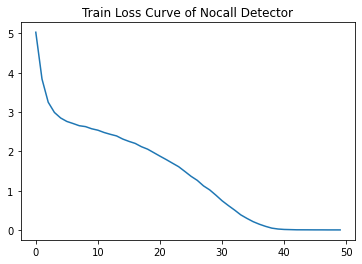

In [17]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

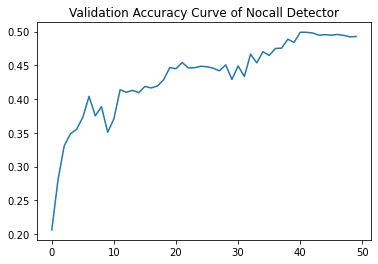

In [18]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

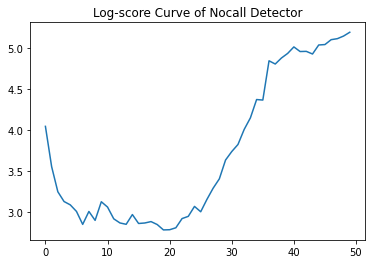

In [19]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

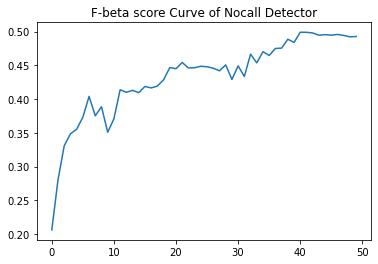

In [20]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 49.49
Log Loss score:	5.03
Fbeta-score (beta=1.0): 	0.49
